In [1]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
import pprint
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from onnxmltools.utils import save_model
import onnxruntime as rt
import onnx
import pyomo.environ as pyo
from omlt.block import OmltBlock
from omlt.gbt import GBTBigMFormulation, GradientBoostedTreeModel
import omlt
import lightgbm as lgb
import onnxmltools.convert.lightgbm.convert

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
# first dataset
df = pd.read_csv("../data/polynomial3.csv")
#retrieve input 'x' and output 'y' from the dataframe
x = df["theta"]
y = df["z"]
df['x'] = df["theta"]
df['y'] = df["z"]

In [25]:
# second dataset
# df = pd.read_csv("../data/sin_quadratic.csv", index_col=[0])
# x = df["x"]
# y = df["y"]

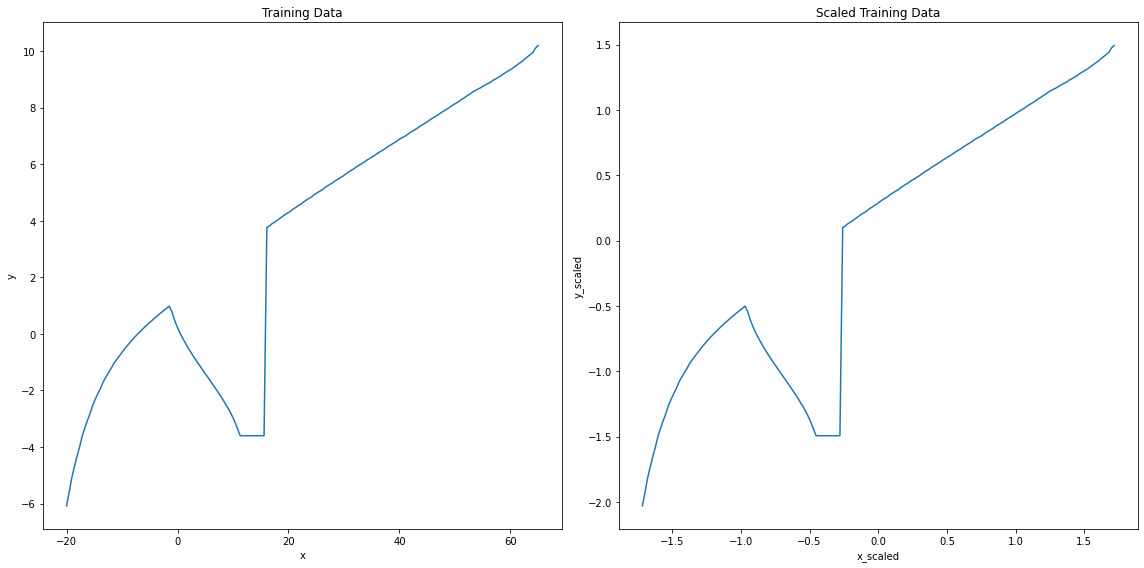

In [26]:
#calculate mean and standard deviation, add scaled 'x' and scaled 'y' to the dataframe
mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

#create plots for unscaled and scaled data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Training Data")

ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled")
ax2.set_title("Scaled Training Data")

plt.tight_layout()

In [27]:
#Data needs to be in array and reshaped
x_scaled = df["x_scaled"].to_numpy().reshape(-1,1)
y_scaled = df["y_scaled"].to_numpy().reshape(-1,1)

c:\Users\yufengq\anaconda3\envs\py39\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\yufengq\anaconda3\envs\py39\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
The maximum opset needed by this model is only 8.


Scaled input bounds:  {0: (-1.7173848751853136, 1.7172339764407347)}


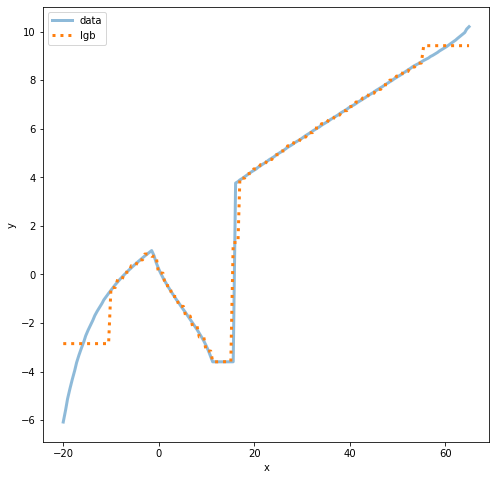

In [28]:
train_data = lgb.Dataset(x_scaled, label=y_scaled)
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 1,
    # "verbosity": 2, # full log
    "verbosity": -1,
    # 'linear_tree': True,
    'num_iterations': 100,
}

model_lgb = lgb.train(params, train_data)
y_pred_lgb = model_lgb.predict(x_scaled)
y_predict_lgb = y_pred_lgb * (std_data['y']) + mean_data['y']

#create a single plot with the original data and each neural network's predictions
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.plot(x, y, linewidth=3.0, label="data", alpha=0.5)
ax.plot(x, y_predict_lgb, linewidth=3.0,
        linestyle="dotted", label="lgb")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

#create an omlt scaling object
scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                    factor_inputs=[std_data['x']],
                    offset_outputs=[mean_data['y']],
                    factor_outputs=[std_data['y']])

#create the input bounds. note that the key `0` corresponds to input `0` and that we also scale the input bounds
input_bounds={0:((min(df['x']) - mean_data['x'])/std_data['x'],
                 (max(df['x']) - mean_data['x'])/std_data['x'])};
print(scaler)
print("Scaled input bounds: ",input_bounds)

initial_type = [('float_input', FloatTensorType([-1, 1]))]
onnx_model_lgb = onnxmltools.convert_lightgbm(model_lgb, initial_types=initial_type)

In [29]:
#create a GradientBoostedTreeModel Object
boostingmodel = GradientBoostedTreeModel(onnx_model_lgb,
                                         scaler, input_bounds)
#create a pyomo model with variables x and y
model1 = pyo.ConcreteModel()
model1.x = pyo.Var(initialize=0)
model1.y = pyo.Var(initialize=0)
model1.obj = pyo.Objective(expr=(model1.y))

#create an OmltBlock
model1.bt = OmltBlock()

#use the reduced-space formulation
formulation1_bt = GBTBigMFormulation(boostingmodel)
model1.bt.build_formulation(formulation1_bt)

#connect pyomo variables to the neural network
@model1.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.bt.inputs[0]

@model1.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.bt.outputs[0]

#solve the model and query the solution
status_1_bt = pyo.SolverFactory("gurobi", solver_io="python").solve(model1, tee=True)
solution_1_bt = (pyo.value(model1.x),pyo.value(model1.y))

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1390 rows, 726 columns and 4764 nonzeros
Model fingerprint: 0x6ddd235f
Variable types: 680 continuous, 46 integer (46 binary)
Coefficient statistics:
  Matrix range     [7e-11, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 7e+01]
  RHS range        [6e-02, 3e+00]
Presolve removed 315 rows and 205 columns
Presolve time: 0.07s
Presolved: 1075 rows, 521 columns, 3925 nonzeros
Variable types: 475 continuous, 46 integer (46 binary)
Found heuristic solution: objective 7.6192385
Found heuristic solution: objective 4.7323960
Found heuristic solution: objective 0.7447074

Root relaxation: objective -3.600414e+00, 249 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Ex

In [30]:
#print out model size and solution values
print("Reduced Space Solution:")
print("# of variables: ", model1.nvariables())
print("# of constraints: ", model1.nconstraints())
print("x = ", solution_1_bt[0])
print("y = ", solution_1_bt[1])
# print("Solve Time: ", status_1_bt['Solver'][0]['Time'])

Reduced Space Solution:
# of variables:  726
# of constraints:  1390
x =  11.099999885312828
y =  -3.6004137250453243


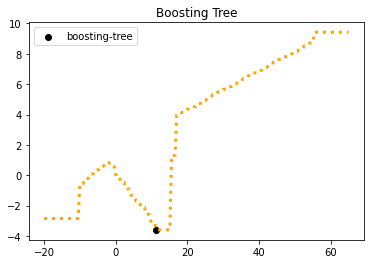

In [31]:
plt.plot(x, y_predict_lgb,linewidth = 3.0,linestyle="dotted",color = "orange")
plt.title("Boosting Tree")
plt.scatter([solution_1_bt[0]],[solution_1_bt[1]],color = "black", label="boosting-tree")
plt.legend()

In [32]:
x_point = np.array((pyo.value(model1.x) -  mean_data['x']) / std_data['x']) 
y_point = model_lgb.predict(x_point.reshape(-1, 1))
y_point = y_point * (std_data['y']) + mean_data['y']
y_point

array([-3.15823065])